In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm
tqdm.pandas()

pd.set_option('max_colwidth', None)
pd.set_option('display.width', None)

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

In [2]:
from sklearn.decomposition import PCA
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

STOPWORDS = set(stopwords.words('english'))
PUNCT_TO_REMOVE = string.punctuation.replace("/", "")
lemmatizer = WordNetLemmatizer()


def remove_numbers(text):
    return re.sub(r'\d+', '', text)


def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])


def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))


def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])


def longest_word(s):
    return max(s.split(), key=len)


def longest_word_in_list(l):
    try:
        words_list = []
        for s in l:
            words = s.strip(" /").split()
            words_list.append(max(words, key=len))
    except Exception as e:
        print(l)
        raise e
    return " / ".join(words_list)


def get_last(s):
    return s.split()[-1]


def target_encode(df: pd.DataFrame, group_col: str, target_col: str):
    target_means = df.groupby(group_col)[target_col].mean().sort_values(ascending=True)
    group_ranking = (target_means.rank() - target_means.rank().min()) / (target_means.rank() - target_means.rank().min()).max()
    return group_ranking.to_dict()

# 1. Load data

In [4]:
crashes = pd.read_csv('data/clean_crashes.csv', 
                      usecols=['Date', 'Location', 'Operator', 'Type', 'Aboard', 'Fatalities', 'Ground', 'Summary'])
crashes.Date = pd.to_datetime(crashes.Date)
crashes.tail(1)

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary
4830,2009-06-08,"State of Arunachal Pradesh, India",Military - Indian Air Force,Antonov An-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.


## 1.1. Get summary clusters

In [5]:
crashes_summary_clustered = pd.read_csv('data/clean_crashes.clustered_summary.csv', 
                                        sep='\t', usecols=['Unnamed: 0','Cluster','Cluster_name'])
crashes_summary_clustered = crashes_summary_clustered.rename(columns={'Unnamed: 0': "Index", 
                                                                      'Cluster': "Summary_Cluster", 
                                                                      'Cluster_name': "Summary_Cluster_name"})
crashes_summary_clustered = crashes_summary_clustered.set_index('Index')
crashes_summary_clustered.tail(1)

,Summary_Cluster,Summary_Cluster_name
Index,,
4830,15,Disappeared en route


In [6]:
crashes = crashes.join(crashes_summary_clustered)
crashes.tail(1)

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Summary_Cluster,Summary_Cluster_name
4830,2009-06-08,"State of Arunachal Pradesh, India",Military - Indian Air Force,Antonov An-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.,15,Disappeared en route


# 2. Transform data

## Create 'Mortality' column

In [7]:
crashes['mortality'] = crashes.apply(lambda row: round(row.Fatalities / row.Aboard, 2) if row.Aboard != 0 else 0, axis=1)
crashes.tail(2)

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Summary_Cluster,Summary_Cluster_name,mortality
4829,2009-06-07,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,Britten-Norman BN-2A-27 Islander,1.0,1.0,0.0,The air ambulance crashed into hills while attempting to land in heavy fog about 4 miles from the airport.,13,Fog,1.0
4830,2009-06-08,"State of Arunachal Pradesh, India",Military - Indian Air Force,Antonov An-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.,15,Disappeared en route,1.0


In [8]:
round(crashes.mortality.mean(), 4),  round(crashes.mortality.std(), 4)

(0.8284, 0.3047)

## Create 'Military plane' column

In [9]:
crashes['is_military'] = crashes.Operator.str.lower().str.contains("army|navy|military|force|marine|corps")
crashes.tail(2)

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Summary_Cluster,Summary_Cluster_name,mortality,is_military
4829,2009-06-07,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,Britten-Norman BN-2A-27 Islander,1.0,1.0,0.0,The air ambulance crashed into hills while attempting to land in heavy fog about 4 miles from the airport.,13,Fog,1.0,False
4830,2009-06-08,"State of Arunachal Pradesh, India",Military - Indian Air Force,Antonov An-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.,15,Disappeared en route,1.0,True


In [10]:
round(crashes.is_military.mean(), 4),  round(crashes.is_military.std(), 4)

(0.153, 0.36)

## Type column

In [11]:
replacement = {'helicopters': 'helicopter',
#                "ilushin": "ilyushin",
#                "illyushin": "ilyushin",
#                "iluyshin": "ilyushin",
#                "illyushin": "ilyushin",
#                "ilysushin": "ilyushin"
              }

In [12]:
crashes.Type = crashes.Type.str.lower()
crashes.Type = crashes.Type.replace(replacement)
# crashes.Type.value_counts()

In [13]:
crashes['plane_series'] = crashes.Type.apply(remove_numbers)
crashes.plane_series = crashes.plane_series.apply(remove_punctuation)
crashes.plane_series = crashes.plane_series.str.strip(" /.,")
crashes.plane_series = crashes.plane_series.str.split("/").progress_apply(lambda x: longest_word_in_list(x))

  0%|          | 0/4831 [00:00<?, ?it/s]

In [14]:
crashes.plane_series.value_counts().head(10)  # mcdonnell = douglas ?

douglas       895
boeing        314
havilland     244
lockheed      242
antonov       230
cessna        175
mcdonnell     120
beechcraft    116
curtiss       111
piper          95
Name: plane_series, dtype: int64

In [15]:
series_encoding_dict = target_encode(crashes, group_col='plane_series', target_col='mortality')
crashes['series_encoded'] = crashes.plane_series.progress_apply(lambda x: series_encoding_dict[x])
crashes.tail(2)

  0%|          | 0/4831 [00:00<?, ?it/s]

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Summary_Cluster,Summary_Cluster_name,mortality,is_military,plane_series,series_encoded
4829,2009-06-07,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,britten-norman bn-2a-27 islander,1.0,1.0,0.0,The air ambulance crashed into hills while attempting to land in heavy fog about 4 miles from the airport.,13,Fog,1.0,False,brittennorman,0.361963
4830,2009-06-08,"State of Arunachal Pradesh, India",Military - Indian Air Force,antonov an-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.,15,Disappeared en route,1.0,True,antonov,0.453988


## Location column

In [16]:
replacements = {  # what am i doing with my life
    'ussr': 'russia',
    'russian': 'russia',
    'minnisota': 'minnesota',
    'islands': 'island',
    'atlantiocean': 'ocean',
    'pacifiocean': 'ocean',
    'atlantic': 'ocean',
    'baltisea': 'sea',
    'democratirepublicongo': 'congo',
    'democratirepublicogo': 'congo',
    'democtratirepublicongo': 'congo',
    'democratirepubliof congo': 'congo',
    'somalia': 'somali',
    'somaliland': 'somali',
    'massachusett': 'massachusetts',
    'massachutes': 'massachusetts',
    'alaksa': 'alaska',
    'alakska': 'alaska',
    'nwtcanada': 'canada',
    'quebecanada': 'canada',
    'indochina': 'vietnam',
    'washingon': 'washington',
    'inodnesia': 'indonesia',
    'indian': 'india',
    'airzona': 'arizona',
    'baangladesh': 'bangladesh',
    'aregntina': 'argentina',
    'jamacia': 'jamaica',
    'napal': 'nepal',
    'afghanstan': 'afghanistan',
    'dekota': 'dakota',
    'calilfornia': 'california',
    'cailifornia': 'california',
    'yugosalvia': 'yugoslavia',
    'thilandd': 'thailand',
    'thiland': 'thailand',
    'besarthailand': 'thailand',
    'iloilophilippines': 'philippines',
    'philipines': 'philippines',
    'moscow': 'russia',
    'bulgeria': 'bulgaria',
    'oklohoma': 'oklahoma',
    'romainia': 'romania',
    'ilinois': 'illinois',
    'herzegovina': 'bosniaherzegovina',
    'coloado': 'colorado',
    'louisana': 'louisiana',
    'stromfjordgreenland': 'greenland',
    'labrador': 'canada',
    'arazona': 'arizona',
    'alalaskaska': 'alaska',
    'reunion': 'union',
    'tonkindiadia': 'india',
    'tonkindia': 'india',
    'dc': 'columbia',
    'ak': 'alaska',
    'ca': 'canada',
    'uk': 'kingdom',
    'ga': 'georgia',
    'nag': 'india',
    'in': 'india',
    'ny': 'york',
    'bo': 'bolivia',
    'hi': 'hawaii',
    'boliva': 'bolivia',
    'bugaria': 'bulgaria',
    'columbia': 'colombia',
    'cameroons': 'cameroon',
    'deleware': 'delaware',
    'djbouti': 'djibouti',
    'england': 'kingdom',
    'indies': 'indonesia',
    'malaya': 'malaysia',
    'mauritania': 'mauretania',
    'morroco': 'morocco',
    'morrocco': 'morocco',
    'phillipines': 'philippines',
    'rico': 'rica',
    'surinam': 'suriname',
    'wisconson': 'wisconsin'
}

In [17]:
crashes['loc_clean'] = crashes.Location.apply(remove_numbers)
crashes.loc_clean = crashes.loc_clean.apply(remove_punctuation)
crashes.loc_clean = crashes.loc_clean.str.lower().str.strip()
crashes.loc_clean = crashes.loc_clean.apply(get_last)
crashes.loc_clean = crashes.loc_clean.replace(replacements)
crashes.tail(2)

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Summary_Cluster,Summary_Cluster_name,mortality,is_military,plane_series,series_encoded,loc_clean
4829,2009-06-07,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,britten-norman bn-2a-27 islander,1.0,1.0,0.0,The air ambulance crashed into hills while attempting to land in heavy fog about 4 miles from the airport.,13,Fog,1.0,False,brittennorman,0.361963,canada
4830,2009-06-08,"State of Arunachal Pradesh, India",Military - Indian Air Force,antonov an-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.,15,Disappeared en route,1.0,True,antonov,0.453988,india


## Operator column

In [18]:
def clean_operator(input_text: str):
    operators_ditry = input_text.split("/")
    operators = set()
    for operator in operators_ditry:
        operator = operator.strip()
        operator = operator.replace(".", "")
        operator = operator.replace("  ", " ")
        
        operator = operator.replace("í", "i")
        operator = operator.replace("ú", "u")
        operator = operator.replace("é", "e")
        
        operator = operator.replace("air taxi - ", "")
        operator = operator.replace(" - taxi", "")
        operator = operator.replace(" - air taxi", "")
        operator = operator.replace("military - ", "")
        operator = operator.replace("military -", "")
        operator = operator.replace("mililtary - ", "")
        operator = operator.replace("military ", "")
        operator = operator.replace("miltiary -", "")
        
        operator = operator.replace("bhs - ", "")
        operator = operator.replace(" inc", "")
        operator = operator.replace("private - ", "")
        operator = operator.replace("charter - ", "")
        operator = operator.replace(" - charter", "")
        
        
        operator = operator.replace("ecuadorean", "ecuadorian")
        operator = operator.replace("procuradoria", "procuraduria")
        operator = operator.replace("procurator", "procuraduria")
        operator = operator.replace("a b aerotransport", "ab aerotransport")
        operator = operator.replace("u s ", "us ")
        operator = operator.replace("", "")
        operator = operator.strip()
        operators.add(operator)

    return " / ".join(operators)

In [19]:
crashes.Operator = crashes.Operator.str.lower()
crashes['Operator_clean'] = crashes.Operator.apply(lambda x: clean_operator(x))
crashes.tail(2)

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Summary_Cluster,Summary_Cluster_name,mortality,is_military,plane_series,series_encoded,loc_clean,Operator_clean
4829,2009-06-07,"Near Port Hope Simpson, Newfoundland, Canada",strait air,britten-norman bn-2a-27 islander,1.0,1.0,0.0,The air ambulance crashed into hills while attempting to land in heavy fog about 4 miles from the airport.,13,Fog,1.0,False,brittennorman,0.361963,canada,strait air
4830,2009-06-08,"State of Arunachal Pradesh, India",military - indian air force,antonov an-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.,15,Disappeared en route,1.0,True,antonov,0.453988,india,indian air force


In [20]:
crashes.Operator_clean.value_counts().head(10)

us air force                  180
aeroflot                      166
air france                     62
royal air force                52
deutsche lufthansa             50
air taxi                       49
united air lines               44
us army air forces             44
us navy                        42
pan american world airways     41
Name: Operator_clean, dtype: int64

In [21]:
# unio = crashes.Operator_clean.sort_values(ascending=True).unique()
# unio[:100]

Let's encode rankings by mean death value of operator

In [22]:
operator_encoding_dict = target_encode(crashes, 'Operator_clean', 'mortality')
crashes['operator_encoded'] = crashes.Operator_clean.progress_apply(lambda x: operator_encoding_dict[x])
crashes.tail(2)

  0%|          | 0/4831 [00:00<?, ?it/s]

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Summary_Cluster,Summary_Cluster_name,mortality,is_military,plane_series,series_encoded,loc_clean,Operator_clean,operator_encoded
4829,2009-06-07,"Near Port Hope Simpson, Newfoundland, Canada",strait air,britten-norman bn-2a-27 islander,1.0,1.0,0.0,The air ambulance crashed into hills while attempting to land in heavy fog about 4 miles from the airport.,13,Fog,1.0,False,brittennorman,0.361963,canada,strait air,1.000000
4830,2009-06-08,"State of Arunachal Pradesh, India",military - indian air force,antonov an-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.,15,Disappeared en route,1.0,True,antonov,0.453988,india,indian air force,0.520833


## Date column (removed)

In [23]:
# crashes['date_year'] = crashes.Date.dt.year
# crashes['date_month'] = crashes.Date.dt.month
# crashes['date_day'] = crashes.Date.dt.day
# crashes['date_day_of_week'] = crashes.Date.dt.day_of_week
# crashes['date_day_of_year'] = crashes.Date.dt.day_of_year

# crashes[['Date', 'date_year', 'date_month', 'date_day', 'date_day_of_week', 'date_day_of_year']].tail(1)

In [24]:
# crashes['Date_is_year_start'] = crashes.Date.dt.is_year_start
# crashes['Date_is_quarter_start'] = crashes.Date.dt.is_quarter_start
# crashes['Date_is_month_start'] = crashes.Date.dt.is_month_start
# crashes['Date_is_month_end'] = crashes.Date.dt.is_month_end

# crashes[['Date_is_year_start', 'Date_is_quarter_start', 'Date_is_month_start', 'Date_is_month_end']].tail(1)

In [25]:
# crashes['Date_is_weekend'] = np.where(crashes['date_day_of_week'].isin([5,6]), 1,0)
# crashes[['Date','date_day_of_week','Date_is_weekend']].tail(1)

## Categorize by plane size

<AxesSubplot:>

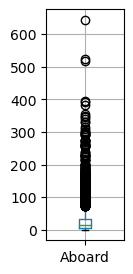

In [26]:
crashes.boxplot(['Aboard'], figsize=(1,3))

array([[<AxesSubplot:title={'center':'Aboard'}>]], dtype=object)

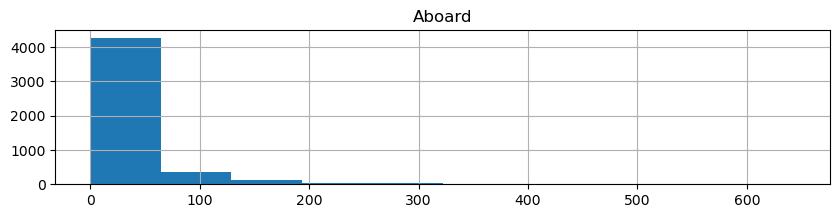

In [27]:
crashes.hist('Aboard', figsize=(10,2))

Convert number of passengers (Aboard) to [0,1]

In [28]:
scaler = MinMaxScaler(clip=True)

scaler.fit(crashes[crashes.Aboard < 100].Aboard.values.reshape(-1, 1))
crashes['Aboard_scaled'] = scaler.transform(crashes.Aboard.values.reshape(-1, 1))

<AxesSubplot:>

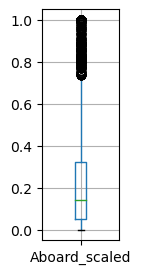

In [29]:
crashes.boxplot(['Aboard_scaled'], figsize=(1,3))

# 3. Reviewing the summary column

In [30]:
crashes.Summary_Cluster_name.value_counts()

Fire / explosion        424
Land / take off         380
Engine failure (v3)     359
Cargo (plane)           356
Engine failure (v2)     356
En route / Mountains    338
Pilot error             307
Crash                   305
Engine failure          288
Landing attempt         242
Weather / landing       225
Crashed into sea        219
Weather conditions      210
Fog                     204
Midair collision        133
Disappeared en route    125
Shot down               118
Helicopter              118
Mountains                82
Mail plane               42
Name: Summary_Cluster_name, dtype: int64

In [31]:
cluster_stats = crashes.groupby('Summary_Cluster_name') \
                       .agg({"Aboard_scaled": np.mean,
                             "mortality": np.mean,
                             "is_military": np.mean,
                            }) \
                       .reset_index(drop=False)

mean_stats = crashes.agg({"Aboard_scaled": [np.mean],
                          "mortality": [np.mean],
                          "is_military": [np.mean],
                         }) \
                    .reset_index(drop=False) \
                    .rename(columns={"index": "Summary_Cluster_name"})

cluster_stats = pd.concat([cluster_stats, mean_stats], ignore_index=True)
cluster_stats['Aboard_scaled_diff'] = (cluster_stats.Aboard_scaled - crashes.Aboard_scaled.mean()).round(2)
cluster_stats['mortality_diff'] = (cluster_stats.mortality - crashes.mortality.mean()).round(2)
cluster_stats['is_military_diff'] = (cluster_stats.is_military - crashes.is_military.mean()).round(2)
cluster_stats

,Summary_Cluster_name,Aboard_scaled,mortality,is_military,Aboard_scaled_diff,mortality_diff,is_military_diff
0,Cargo (plane),0.067189,0.901826,0.019663,-0.19,0.07,-0.13
1,Crash,0.354694,0.833836,0.167213,0.10,0.01,0.01
2,Crashed into sea,0.201974,0.854612,0.187215,-0.05,0.03,0.03
3,Disappeared en route,0.205657,0.982320,0.288000,-0.05,0.15,0.14
4,En route / Mountains,0.195236,0.933284,0.162722,-0.06,0.10,0.01
5,Engine failure,0.199670,0.834826,0.204861,-0.05,0.01,0.05
6,Engine failure (v2),0.312025,0.654944,0.084270,0.06,-0.17,-0.07
7,Engine failure (v3),0.256352,0.786045,0.058496,0.00,-0.04,-0.09
8,Fire / explosion,0.395131,0.743986,0.205189,0.14,-0.08,0.05
9,Fog,0.259061,0.807059,0.063725,0.01,-0.02,-0.09


Выводы:
- В кластерах **Cargo (plane)**, **Mail plane**, **Helicopter** во время полетов было относительно мало пассажиров, потому что это "малые" средства полета.
- В кластерах **Mountains** и **Weather conditions** тоже было мало пассажиров. Возможно проблемы с погодными условиями чаще встречаются среди малых самолетов, потому что их полеты не так хорошо регламентированы.
- Относительно высокая смертность встречается в кластерах **Disappeared en route**, **En route / Mountains**, **Mountains**, **Shot down**. К сожалению, это подтверждает интуицию: в таких случаях действительно гораздо сложнее выжить.
- Военный транспорт чаще встречается в кластерах **Disappeared en route**, **Helicopter**, **Midair collision**, **Mountains**, **Shot down**. 
- Военный транспорт реже встречается в кластерах **Cargo (plane)**, **Mail plane**, **Pilot error**. С первыми двумя понятно, но интересно последнее: наверно в военных самолетах очень опытные пилоты, а основные причины ЧП связаны с внешними факторами.

Из даты не удалось выжать ничего интересного:

In [32]:
# cluster_stats = crashes.groupby('Summary_Cluster_name') \
#                        .agg({"Date_is_weekend": np.mean,
#                             }) \
#                        .reset_index(drop=False)

# mean_stats = crashes.agg({"Date_is_weekend": [np.mean],
#                          }) \
#                     .reset_index(drop=False) \
#                     .rename(columns={"index": "Summary_Cluster_name"})

# cluster_stats = pd.concat([cluster_stats, mean_stats], ignore_index=True)
# cluster_stats['is_weekend_diff'] = (cluster_stats.Date_is_weekend - crashes.Date_is_weekend.mean()).round(2)
# cluster_stats

One-hot encode summary clusters

In [33]:
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
summary_cluster_encoded = one_hot_encoder.fit_transform(crashes['Summary_Cluster_name'].values.reshape(-1,1))
summary_cluster_encoded_df = pd.DataFrame(summary_cluster_encoded, columns=one_hot_encoder.categories_[0])
crashes = crashes.join(summary_cluster_encoded_df)
crashes.tail(1)

,Date,Location,Operator,Type,Aboard,Fatalities,Ground,Summary,Summary_Cluster,Summary_Cluster_name,...,Helicopter,Land / take off,Landing attempt,Mail plane,Midair collision,Mountains,Pilot error,Shot down,Weather / landing,Weather conditions
4830,2009-06-08,"State of Arunachal Pradesh, India",military - indian air force,antonov an-32,13.0,13.0,0.0,The military transport went missing while en route and might have crashed due to heavy rain in the mountainous region.,15,Disappeared en route,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Clusterize

In [34]:
def get_cluster_stats(df: pd.DataFrame, summary_cluster: bool = False):
    cluster_stats = df.groupby('cluster') \
                      .agg({"mortality": np.mean,
                            "is_military": np.mean,
                            "series_encoded": np.mean,
                            "operator_encoded": np.mean,
                            "Aboard_scaled": np.mean})
    return cluster_stats


def create_cluster_name(row):
    stats_name = [f"mor_{round(row.mortality, 1)}",
                  f"mil_{round(row.is_military, 1)}",
                  f"ser_{round(row.series_encoded, 1)}",
                  f"op_{round(row.operator_encoded, 1)}",
                  f"ab_{round(row.Aboard_scaled, 1)}"
                 ]
    return "/".join(stats_name)


def get_cluster_names(df: pd.DataFrame, clusters, summary_cluster: bool = False):
    df_1 = df.copy()
    df_1['cluster'] = clusters
    cluster_stats = get_cluster_stats(df_1, summary_cluster)
    cluster_stats['cluster_name'] = cluster_stats.apply(lambda row: create_cluster_name(row), axis=1)
    return cluster_stats['cluster_name'].to_dict()

In [35]:
def plot_clusters(reduced_embeddings, clusters, cluster_names):
    fig, ax = plt.subplots()

    scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, s=0.1, cmap='Spectral')
    legend1 = ax.legend(scatter.legend_elements()[0], cluster_names.values(), 
                        loc="best", fontsize=10, bbox_to_anchor=(1.0, 1.00))
    ax.add_artist(legend1)

    plt.show()

## v1 No summary info

In [36]:
cols_to_cluster_1 = ['mortality', 'is_military', 'series_encoded', 'operator_encoded', 'Aboard_scaled']
cols_to_show_1 = cols_to_cluster_1

In [37]:
crashes_cluster_1 = crashes[cols_to_cluster_1]
crashes_cluster_1.tail(1)

,mortality,is_military,series_encoded,operator_encoded,Aboard_scaled
4830,1.0,True,0.453988,0.520833,0.131313


In [38]:
len(crashes_cluster_1[crashes_cluster_1.mortality == 1]) / len(crashes_cluster_1)

0.6594907886565928

In [39]:
len(crashes_cluster_1[crashes_cluster_1.mortality == 0]) / len(crashes_cluster_1)

0.013040778306768785

### Cluster

In [40]:
hdbscan_model = HDBSCAN(min_cluster_size=80, min_samples=1, prediction_data=False)
clusters_hdbscan_1 = hdbscan_model.fit_predict(crashes_cluster_1)

clusters_hdbscan_1_names = get_cluster_names(crashes_cluster_1, clusters_hdbscan_1)
clusters_hdbscan_1_names[-1] = -1

clustered = (clusters_hdbscan_1 >= 0)
print(f"Total clusters: {len(set(clusters_hdbscan_1))}")
print(f"Clustered: {(np.sum(clustered) / len(clusters_hdbscan_1)):.4f}")
print(f"Silhouette: {silhouette_score(crashes_cluster_1, clusters_hdbscan_1):.4f}")

Total clusters: 5
Clustered: 1.0000
Silhouette: 0.3730


In [41]:
# min_cluster_size=50, min_samples=10
# Total clusters: 7
# Clustered: 0.9932
# Silhouette: 0.3566

# min_cluster_size=80, min_samples=10
# Total clusters: 6
# Clustered: 0.9936
# Silhouette: 0.3693

# min_cluster_size=80, min_samples=5
# Total clusters: 6
# Clustered: 0.9983
# Silhouette: 0.3707

# min_cluster_size=30, min_samples=1
# Total clusters: 10
# Clustered: 0.9973
# Silhouette: 0.3445

# ============= BEST =============
# min_cluster_size=50, min_samples=1
# Total clusters: 6
# Clustered: 1.0000
# Silhouette: 0.3650


# min_cluster_size=80, min_samples=1
# Total clusters: 5
# Clustered: 1.0000
# Silhouette: 0.3730

### Visualize

In [55]:
umap_encoder = UMAP(n_neighbors=100, n_components=2, min_dist=0.0, metric='euclidean', random_state=42)
reduced_emb_1 = umap_encoder.fit_transform(crashes_cluster_1)

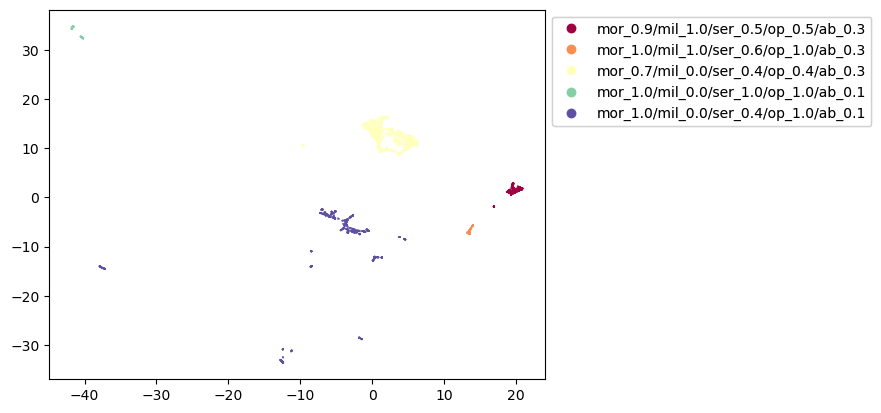

In [56]:
plot_clusters(reduced_emb_1, clusters_hdbscan_1, clusters_hdbscan_1_names)

## v2 Cluster every summary cluster

In [57]:
cols_to_cluster_2 = ['mortality', 'is_military', 'series_encoded', 'operator_encoded', 
                   'Aboard_scaled', *one_hot_encoder.categories_[0]]
cols_to_show_2 = ['mortality', 'is_military', 'series_encoded', 'operator_encoded', 'Aboard_scaled', 'Summary_Cluster_name']

In [58]:
crashes_cluster_2 = crashes[cols_to_cluster_2]
crashes_cluster_2.tail(1)

,mortality,is_military,series_encoded,operator_encoded,Aboard_scaled,Cargo (plane),Crash,Crashed into sea,Disappeared en route,En route / Mountains,...,Helicopter,Land / take off,Landing attempt,Mail plane,Midair collision,Mountains,Pilot error,Shot down,Weather / landing,Weather conditions
4830,1.0,True,0.453988,0.520833,0.131313,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Cluster

In [75]:
hdbscan_model = HDBSCAN(min_cluster_size=32, min_samples=1, prediction_data=False)
clusters_hdbscan_2 = hdbscan_model.fit_predict(crashes_cluster_2)

clusters_hdbscan_2_names = get_cluster_names(crashes_cluster_2, clusters_hdbscan_2)
clusters_hdbscan_2_names[-1] = -1

clustered = (clusters_hdbscan_2 >= 0)
print(f"Total clusters: {len(set(clusters_hdbscan_2))}")
print(f"Clustered: {(np.sum(clustered) / len(clusters_hdbscan_2)):.4f}")
print(f"Silhouette: {silhouette_score(crashes_cluster_2, clusters_hdbscan_2):.4f}")

Total clusters: 48
Clustered: 0.9712
Silhouette: 0.4411


In [ ]:
# min_cluster_size=80, min_samples=1
# Total clusters: 27
# Clustered: 0.9549
# Silhouette: 0.4311

# min_cluster_size=40, min_samples=1
# Total clusters: 43
# Clustered: 0.9725
# Silhouette: 0.4347

# min_cluster_size=35, min_samples=1
# Total clusters: 46
# Clustered: 0.9725
# Silhouette: 0.4398

# min_cluster_size=32, min_samples=1
# Total clusters: 48
# Clustered: 0.9712
# Silhouette: 0.4411

### Visualize

In [76]:
umap_encoder = UMAP(n_neighbors=100, n_components=2, min_dist=0.0, metric='cosine', random_state=42)
reduced_emb_2 = umap_encoder.fit_transform(crashes_cluster_2)

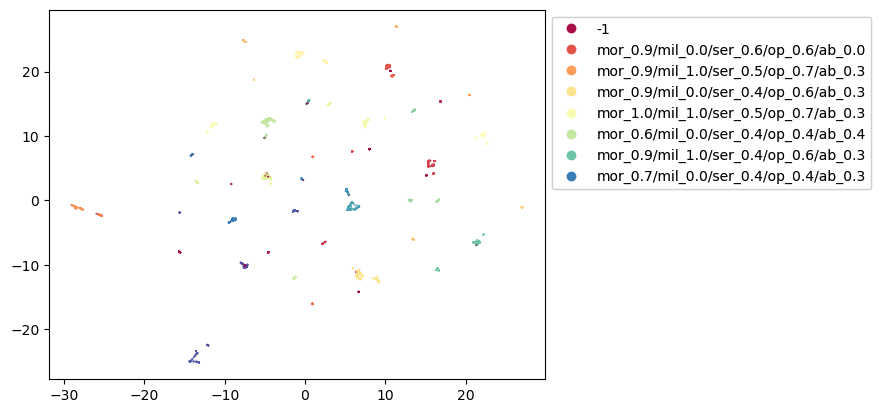

In [77]:
plot_clusters(reduced_emb_2, clusters_hdbscan_2, clusters_hdbscan_2_names)